In [1]:
!pip install ultralytics kagglehub pandas numpy matplotlib opencv-python seaborn scikit-learn

In [2]:
# Import và Kiểm tra phần cứng
import torch
import os
from ultralytics import YOLO

from IPython.display import clear_output
clear_output()

print(f"PyTorch Version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"Đã kết nối GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Đang chạy bằng CPU. Hãy kiểm tra lại Driver NVIDIA.")

PyTorch Version: 2.9.1+cu126
Đã kết nối GPU: NVIDIA GeForce GTX 1660 Ti


In [3]:
# Tải và Xử lý dữ liệu
import kagglehub
import shutil
import random
import os
from pathlib import Path

# --- 1. Tải hoặc xác định dữ liệu ---
print("Đang tải/kiểm tra dữ liệu từ Kaggle...")
# Tải về 
download_path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
print(f"Đường dẫn tải về gốc: {download_path}")

# --- 2. Quét folder garbage-dataset ---
print("Đang quét folder")

data_root = None

target_classes = {'battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash'}

for root, dirs, files in os.walk(download_path):
    # Kiểm tra xem folder hiện tại có chứa các folder rác không
    current_dirs = set(d.lower() for d in dirs)
    
    if target_classes.issubset(current_dirs):
        data_root = Path(root)
        print(f"ĐÃ TÌM THẤY dữ liệu tại: {data_root}")
        break

if data_root is None:
    print("LỖI: Không tìm thấy folder dữ liệu nào khớp với cấu trúc trong ảnh!")
else:
    # --- 3. Chia dữ liệu (80% Train - 10% Val - 10% Test) ---
    base_dir = Path("datasets/waste_cls")
    
    # Reset thư mục đích
    if base_dir.exists():
        shutil.rmtree(base_dir)
        
    print(f"Đang copy và chia dữ liệu sang: {base_dir.resolve()}")
    
    # Tạo các thư mục đích
    for split in ['train', 'val', 'test']:
        for cls in os.listdir(data_root):
            if (data_root / cls).is_dir():
                (base_dir / split / cls).mkdir(parents=True, exist_ok=True)

    # Thực hiện chia và copy
    total_count = 0
    classes_found = [d for d in os.listdir(data_root) if (data_root / d).is_dir()]
    
    for cls in classes_found:
        src_folder = data_root / cls
        # Lấy tất cả ảnh (hỗ trợ jpg, png, jpeg, webp...)
        images = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))]
        
        if not images:
            continue
            
        random.shuffle(images)
        count = len(images)
        total_count += count
        
        # Tỷ lệ 8:1:1
        train_end = int(count * 0.8)
        val_end = int(count * 0.9)
        
        splits = {
            'train': images[:train_end],
            'val':   images[train_end:val_end],
            'test':  images[val_end:]
        }
        
        # Copy file
        for split_name, imgs in splits.items():
            dst_folder = base_dir / split_name / cls
            for img_name in imgs:
                shutil.copy2(src_folder / img_name, dst_folder / img_name)
                
    print(f"HOÀN TẤT! Tổng cộng {total_count} ảnh đã được xử lý.")
    print(f"Danh sách lớp: {classes_found}")

Đang tải/kiểm tra dữ liệu từ Kaggle...
Đường dẫn tải về gốc: C:\Users\Windows\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\8
Đang quét folder
ĐÃ TÌM THẤY dữ liệu tại: C:\Users\Windows\.cache\kagglehub\datasets\sumn2u\garbage-classification-v2\versions\8\garbage-dataset
Đang copy và chia dữ liệu sang: D:\Code\python\machine-learning\datasets\waste_cls
HOÀN TẤT! Tổng cộng 19762 ảnh đã được xử lý.
Danh sách lớp: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [4]:
from ultralytics import YOLO

# 1. Load model từ file 
model_path = 'yolov12n-cls.pt'
model = YOLO(model_path) 

print(f"Bắt đầu Train {model_path}")

# 2. Bắt đầu Train
results = model.train(
    data='datasets/waste_cls', # Folder dữ liệu (phải có train/val bên trong)
    epochs=30,                 # Train 30 vòng
    imgsz=224,                 # Size ảnh chuẩn
    batch=16,                  # Batch 16 là mức an toàn và hiệu quả (6GB VRAM)
    device=0,                  # Chạy trên GPU
    project='waste_project',   # Tên folder chứa kết quả
    name='yolov12_run',        # Tên lần chạy này
    exist_ok=True,             # Cho phép ghi đè nếu chạy lại
    plots=True                 # Tự động vẽ biểu đồ sau khi train xong
)

Bắt đầu Train yolov12n-cls.pt
New https://pypi.org/project/ultralytics/8.3.235 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.63  Python-3.13.5 torch-2.9.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
engine\trainer: task=classify, mode=train, model=yolov12n-cls.pt, data=datasets/waste_cls, epochs=30, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=8, project=waste_project, name=yolov12_run, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, r

train: Scanning D:\Code\python\machine-learning\datasets\waste_cls\train... 15806 images, 0 corrupt: 100%|██████████| 15806/15806 [00:19<00:00, 792.77it/s]

train: WARNING  D:\Code\python\machine-learning\datasets\waste_cls\train\cardboard\cardboard_2061.jpg: corrupt JPEG restored and saved
train: WARNING  D:\Code\python\machine-learning\datasets\waste_cls\train\plastic\plastic_2377.jpg: corrupt JPEG restored and saved


train: New cache created: D:\Code\python\machine-learning\datasets\waste_cls\train.cache


val: Scanning D:\Code\python\machine-learning\datasets\waste_cls\val... 1976 images, 0 corrupt: 100%|██████████| 1976/1976 [00:02<00:00, 682.32it/s]

val: New cache created: D:\Code\python\machine-learning\datasets\waste_cls\val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 66 weight(decay=0.0), 67 weight(decay=0.0005), 67 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to waste_project\yolov12_run
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/30     0.526G      2.421         16        224:   1%|          | 10/988 [00:03<02:51,  5.71it/s]

       1/30     0.526G      2.394         16        224:   2%|▏         | 20/988 [00:04<02:00,  8.02it/s]
       1/30     0.526G        2.4         16        224:   2%|▏         | 21/988 [00:05<01:59,  8.12it/s]
       1/30     0.526G      2.399         16        224:   2%|▏         | 22/988 [00:05<01:58,  8.15it/s]
100%|██████████| 755k/755k [00:00<00:00, 2.40MB/s]  224:   2%|▏         | 23/988 [00:05<01:58,  8.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 23.31it/s]

                   all      0.876      0.991



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 24.27it/s]

                   all      0.897      0.994



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 22.68it/s]

                   all      0.902      0.994



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 23.23it/s]

                   all      0.901      0.996



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 22.77it/s]

                   all      0.921      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 24.50it/s]

                   all      0.939      0.996



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 25.58it/s]

                   all      0.931      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 24.56it/s]

                   all      0.941      0.997



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 25.85it/s]

                   all      0.937      0.998



      Epoch    GPU_mem       loss  Instances       Size


      10/30     0.535G      0.255         14        224: 100%|██████████| 988/988 [01:31<00:00, 10.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 22.92it/s]

                   all      0.938      0.997



      Epoch    GPU_mem       loss  Instances       Size


      11/30     0.535G     0.2379         14        224: 100%|██████████| 988/988 [01:32<00:00, 10.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 21.42it/s]

                   all      0.949      0.997



      Epoch    GPU_mem       loss  Instances       Size


      12/30     0.535G     0.2291         14        224: 100%|██████████| 988/988 [01:31<00:00, 10.83it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 23.97it/s]

                   all      0.945      0.998



      Epoch    GPU_mem       loss  Instances       Size


      13/30     0.535G     0.2102         14        224: 100%|██████████| 988/988 [01:31<00:00, 10.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 21.34it/s]

                   all      0.949      0.997



      Epoch    GPU_mem       loss  Instances       Size


      14/30     0.535G     0.1905         14        224: 100%|██████████| 988/988 [01:34<00:00, 10.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 21.89it/s]

                   all      0.947      0.999



      Epoch    GPU_mem       loss  Instances       Size


      15/30     0.535G      0.177         14        224: 100%|██████████| 988/988 [01:35<00:00, 10.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 21.97it/s]

                   all      0.952      0.998



      Epoch    GPU_mem       loss  Instances       Size


      16/30     0.535G     0.1644         14        224: 100%|██████████| 988/988 [01:35<00:00, 10.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 24.02it/s]

                   all       0.95      0.998



      Epoch    GPU_mem       loss  Instances       Size


      17/30     0.535G     0.1512         14        224: 100%|██████████| 988/988 [01:36<00:00, 10.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:03<00:00, 20.48it/s]

                   all      0.959      0.998



      Epoch    GPU_mem       loss  Instances       Size


      18/30     0.535G     0.1341         14        224: 100%|██████████| 988/988 [01:34<00:00, 10.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 23.97it/s]

                   all      0.965      0.999



      Epoch    GPU_mem       loss  Instances       Size


      19/30     0.535G     0.1237         14        224: 100%|██████████| 988/988 [01:36<00:00, 10.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 23.09it/s]

                   all       0.96      0.999



      Epoch    GPU_mem       loss  Instances       Size


      20/30     0.535G     0.1198         14        224: 100%|██████████| 988/988 [01:36<00:00, 10.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 23.73it/s]


                   all      0.964      0.999

      Epoch    GPU_mem       loss  Instances       Size


      21/30     0.535G     0.1067         14        224: 100%|██████████| 988/988 [01:40<00:00,  9.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 21.90it/s]

                   all      0.966      0.999



      Epoch    GPU_mem       loss  Instances       Size


      22/30     0.535G     0.1064         14        224: 100%|██████████| 988/988 [01:39<00:00,  9.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:03<00:00, 20.65it/s]


                   all      0.966      0.999

      Epoch    GPU_mem       loss  Instances       Size


      23/30     0.535G    0.09146         14        224: 100%|██████████| 988/988 [01:39<00:00,  9.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 23.81it/s]

                   all      0.958      0.997



      Epoch    GPU_mem       loss  Instances       Size


      24/30     0.535G    0.07949         14        224: 100%|██████████| 988/988 [01:38<00:00,  9.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 21.51it/s]

                   all      0.962      0.999



      Epoch    GPU_mem       loss  Instances       Size


      25/30     0.535G    0.07294         14        224: 100%|██████████| 988/988 [01:39<00:00,  9.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 21.44it/s]

                   all      0.964      0.999



      Epoch    GPU_mem       loss  Instances       Size


      26/30     0.535G      0.068         14        224: 100%|██████████| 988/988 [01:39<00:00,  9.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 22.57it/s]

                   all      0.967      0.999



      Epoch    GPU_mem       loss  Instances       Size


      27/30     0.535G    0.06519         14        224: 100%|██████████| 988/988 [01:40<00:00,  9.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 21.89it/s]

                   all      0.967      0.999



      Epoch    GPU_mem       loss  Instances       Size


      28/30     0.535G    0.06116         14        224: 100%|██████████| 988/988 [01:40<00:00,  9.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 22.89it/s]

                   all      0.963      0.998



      Epoch    GPU_mem       loss  Instances       Size


      29/30     0.535G    0.05286         14        224: 100%|██████████| 988/988 [01:39<00:00,  9.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 22.39it/s]

                   all      0.962      0.999



      Epoch    GPU_mem       loss  Instances       Size


      30/30     0.535G    0.05466         14        224: 100%|██████████| 988/988 [01:39<00:00,  9.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 23.41it/s]

                   all      0.965      0.999



30 epochs completed in 0.850 hours.
Optimizer stripped from waste_project\yolov12_run\weights\last.pt, 3.6MB
Optimizer stripped from waste_project\yolov12_run\weights\best.pt, 3.6MB

Validating waste_project\yolov12_run\weights\best.pt...
Ultralytics 8.3.63  Python-3.13.5 torch-2.9.1+cu126 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
YOLOv12n-cls summary (fused): 217 layers, 1,674,066 parameters, 0 gradients, 3.0 GFLOPs
train: D:\Code\python\machine-learning\datasets\waste_cls\train... found 15806 images in 10 classes  
val: D:\Code\python\machine-learning\datasets\waste_cls\val... found 1976 images in 10 classes  
test: D:\Code\python\machine-learning\datasets\waste_cls\test... found 1980 images in 10 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 62/62 [00:02<00:00, 22.52it/s]


                   all      0.967      0.999
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to waste_project\yolov12_run


1. Biểu đồ Huấn luyện (Loss & Accuracy):


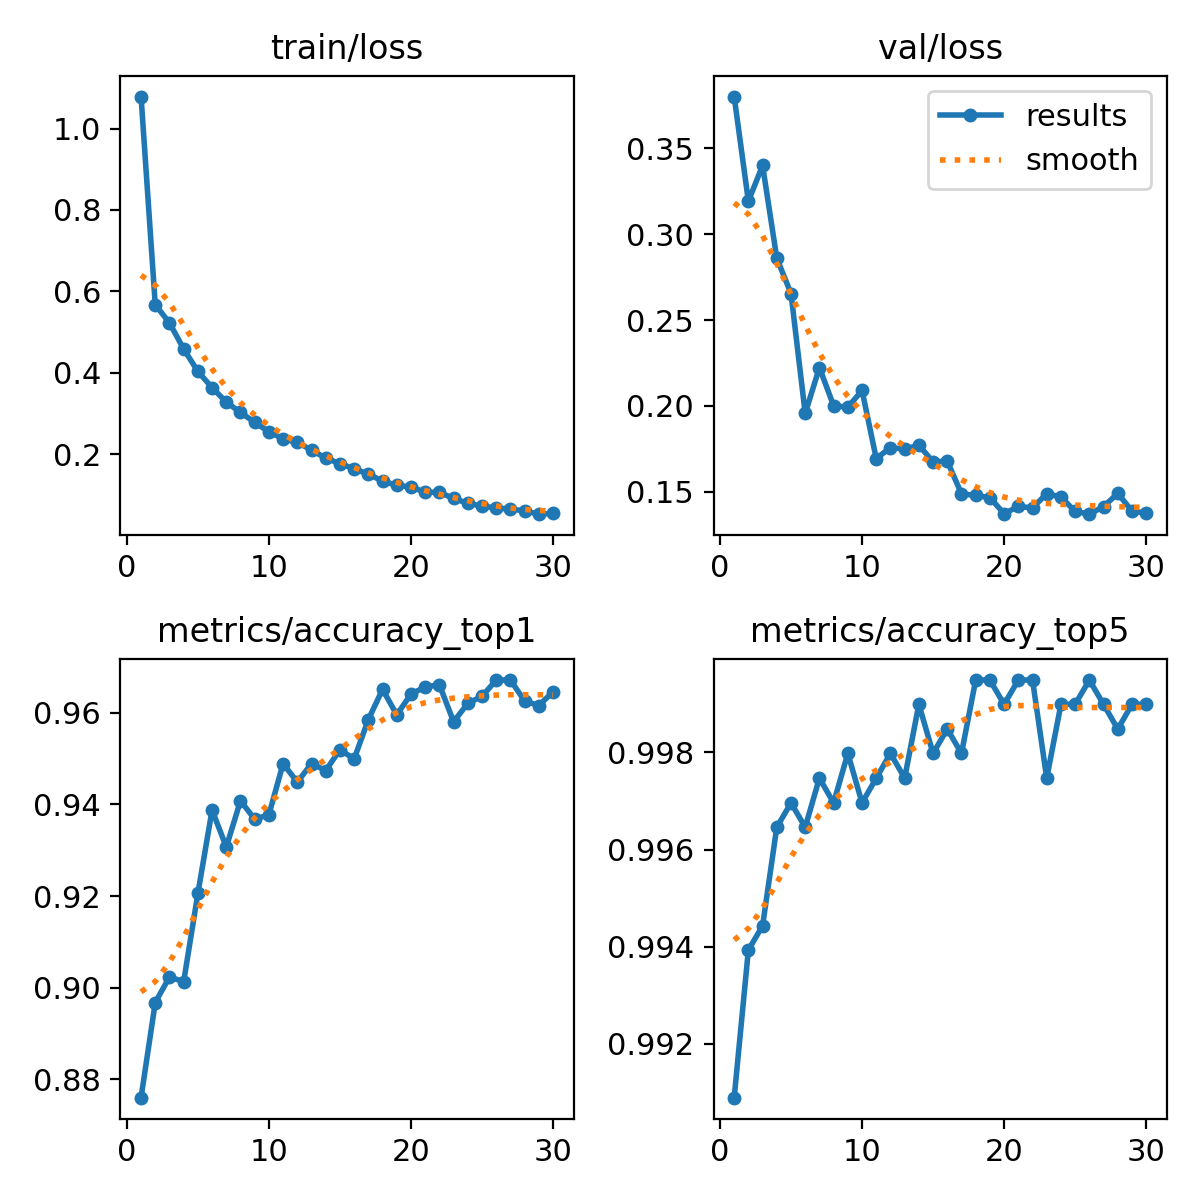


2. Ma trận nhầm lẫn (Confusion Matrix):


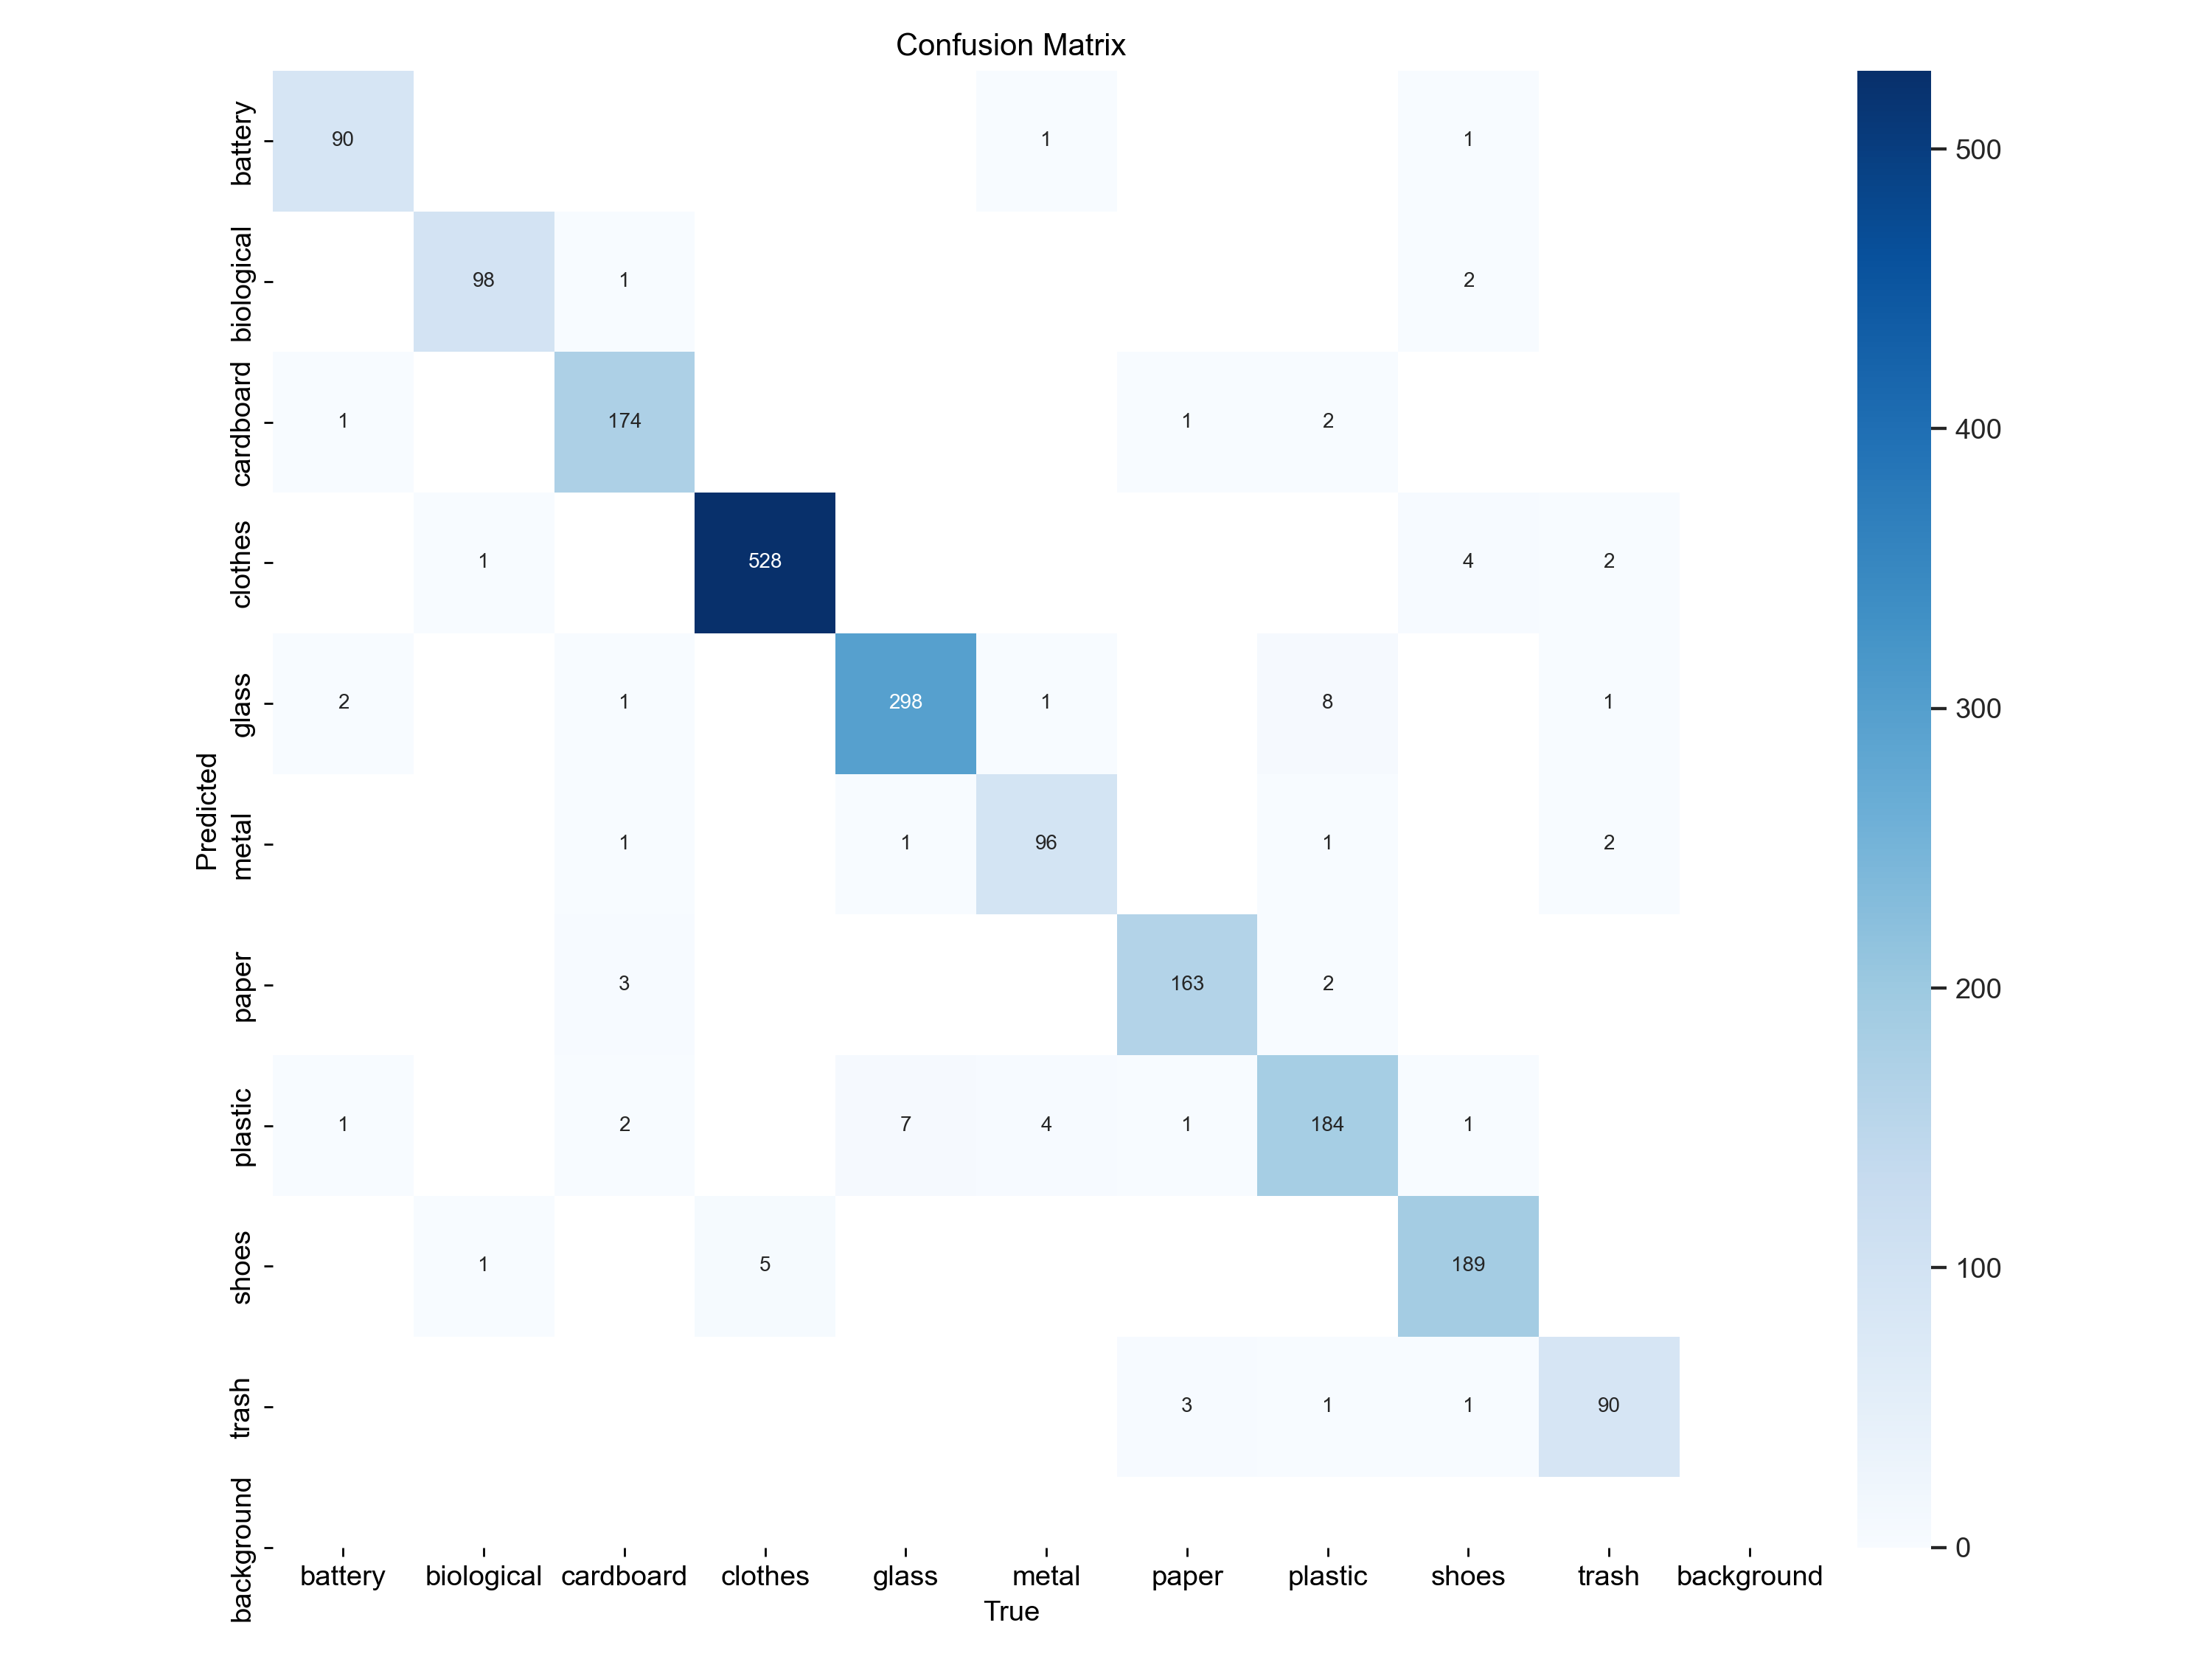

In [22]:
from IPython.display import Image, display, HTML

# --- CẤU HÌNH ĐƯỜNG DẪN ---
run_path = 'waste_project/yolov12_run'

# --- 1. BIỂU ĐỒ QUÁ TRÌNH HUẤN LUYỆN (LOSS & ACCURACY) ---
results_img = os.path.join(run_path, 'results.png')

print(f"1. Biểu đồ Huấn luyện (Loss & Accuracy):")
if os.path.exists(results_img):
    display(Image(filename=results_img, width=800))
else:
    print(f"Không tìm thấy file ảnh tại: {results_img}")

# --- 2. MA TRẬN NHẦM LẪN (CONFUSION MATRIX) ---
cm_img = os.path.join(run_path, 'confusion_matrix.png')

print(f"\n2. Ma trận nhầm lẫn (Confusion Matrix):")
if os.path.exists(cm_img):
    display(Image(filename=cm_img, width=800))
else:
    # Thử tìm bản chuấn hóa nếu bản thường không có
    cm_norm_img = os.path.join(run_path, 'confusion_matrix_normalized.png')
    if os.path.exists(cm_norm_img):
        display(Image(filename=cm_norm_img, width=600))
    else:
        print("Không tìm thấy ảnh Confusion Matrix.")

1. Đang quét tìm file best.pt...
Đã tìm thấy model: waste_project\yolov12_run\weights\best.pt
2. Đang kiểm tra folder: datasets/waste_cls/test
   Tìm thấy các lớp: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
   Tổng số ảnh tìm thấy: 1980
3. Đang chạy dự đoán (Vui lòng chờ)...

Tốc độ trung bình: 48.73 FPS (20.52 ms/ảnh)

4. Đang vẽ biểu đồ ...

=== BÁO CÁO KẾT QUẢ ===
              precision    recall  f1-score   support

     battery       0.96      0.99      0.97        95
  biological       0.94      0.96      0.95       100
   cardboard       0.96      0.98      0.97       183
     clothes       0.99      1.00      0.99       533
       glass       0.95      0.95      0.95       307
       metal       0.94      0.89      0.91       102
       paper       0.96      0.96      0.96       168
     plastic       0.94      0.88      0.91       199
       shoes       0.95      0.97      0.96       198
       trash       0.89   

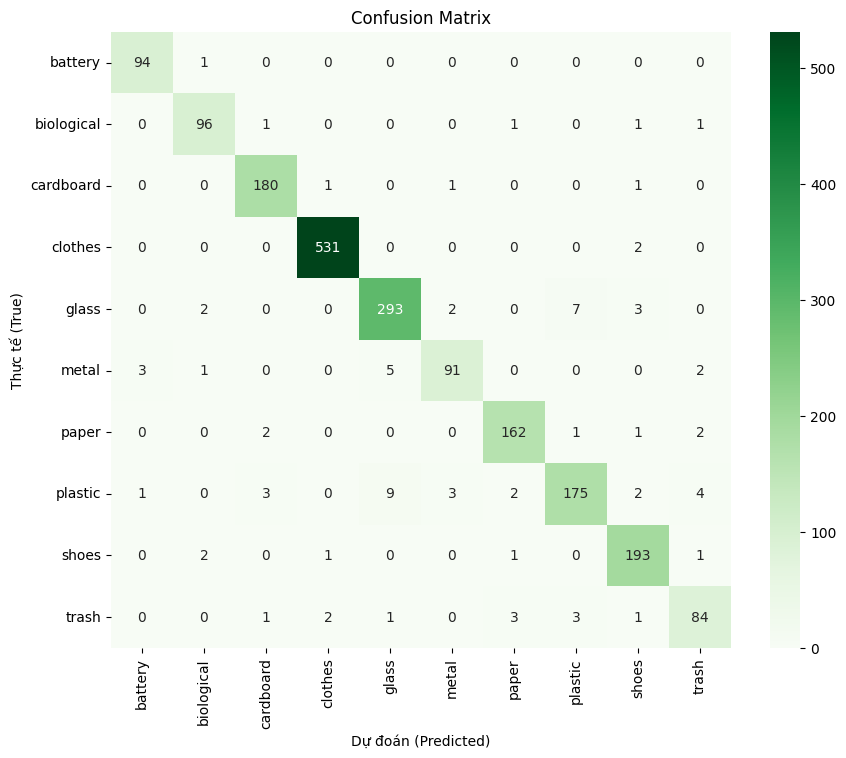

In [21]:
%matplotlib inline 

from ultralytics import YOLO
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time

# --- BƯỚC 1: TÌM FILE MODEL ---
print("1. Đang quét tìm file best.pt...")
found_files = glob.glob('waste_project/**/best.pt', recursive=True)

if not found_files:
    print("Lỗi: Không tìm thấy file 'best.pt' nào. Hãy kiểm tra lại việc train.")
else:
    model_path = found_files[-1]
    print(f"Đã tìm thấy model: {model_path}")
    
    # Load model
    model = YOLO(model_path)
    test_dir = 'datasets/waste_cls/test'

    # --- BƯỚC 2: KIỂM TRA DỮ LIỆU ---
    print(f"2. Đang kiểm tra folder: {test_dir}")
    
    if not os.path.exists(test_dir):
        print(f"Lỗi: Đường dẫn {test_dir} không tồn tại!")
    else:
        # Lấy danh sách ảnh và nhãn
        image_paths = []
        y_true = []
        class_names = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
        
        print(f"   Tìm thấy các lớp: {class_names}")

        for label in class_names:
            folder_path = os.path.join(test_dir, label)
            # Tìm cả đuôi hoa và thường
            for ext in ('*.png', '*.jpg', '*.jpeg'):
                for img_file in glob.glob(os.path.join(folder_path, ext)):
                    image_paths.append(img_file)
                    y_true.append(label)
        
        print(f"   Tổng số ảnh tìm thấy: {len(image_paths)}")

        if len(image_paths) == 0:
            print("Không có ảnh nào để test. Code sẽ dừng tại đây.")
        else:
            # --- BƯỚC 3: DỰ ĐOÁN ---
            print("3. Đang chạy dự đoán (Vui lòng chờ)...")
            
            y_pred = []
            inference_times = []
            for img_path in image_paths:
                t0 = time.time()
                # Dự đoán
                results = model(img_path, verbose=False)
                
                t1 = time.time()
                inference_times.append((t1 - t0) * 1000)
                
                # Lấy kết quả
                pred_idx = results[0].probs.top1
                y_pred.append(results[0].names[pred_idx])
                
            # Tính FPS
            avg_latency = np.mean(inference_times)
            fps = 1000 / avg_latency
            print(f"\nTốc độ trung bình: {fps:.2f} FPS ({avg_latency:.2f} ms/ảnh)")

            # --- BƯỚC 4: VẼ BIỂU ĐỒ ---
            print("\n4. Đang vẽ biểu đồ ...")
            
            try:
                # In báo cáo dạng chữ
                print("\n=== BÁO CÁO KẾT QUẢ ===")
                print(classification_report(y_true, y_pred, target_names=class_names))

                # Vẽ ma trận
                cm = confusion_matrix(y_true, y_pred, labels=class_names)
                
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                            xticklabels=class_names, yticklabels=class_names)
                plt.xlabel('Dự đoán (Predicted)')
                plt.ylabel('Thực tế (True)')
                plt.title('Confusion Matrix')
                
                print("Đang hiển thị ảnh...")
                plt.show()
                
            except Exception as e:
                print(f"Lỗi khi vẽ biểu đồ: {e}")

In [3]:
import cv2
import glob

# --- BƯỚC 1: TỰ ĐỘNG TÌM MODEL ---
found_files = glob.glob('waste_project/**/best.pt', recursive=True)

if not found_files:
    print("Lỗi: Không tìm thấy file 'best.pt'. Bạn hãy kiểm tra lại folder.")
    model_path = None
else:
    model_path = found_files[-1]
    print(f"Đã nạp model từ: {model_path}")

# --- BƯỚC 2: MỞ CAMERA VÀ NHẬN DIỆN ---
if model_path:
    # Load model
    model = YOLO(model_path)
    
    # Mở webcam (Số 0 thường là camera mặc định của laptop/PC)
    cap = cv2.VideoCapture(0)
    
    # Kiểm tra xem camera có mở được không
    if not cap.isOpened():
        print("Lỗi: Không thể mở Camera. Hãy kiểm tra lại quyền truy cập hoặc kết nối.")
    else:
        print("Đang mở Camera... (Bấm phím 'q' để thoát)")
        
        # Cấu hình font chữ
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        while True:
            # 1. Đọc từng khung hình từ camera
            ret, frame = cap.read()
            if not ret:
                print("Không nhận được tín hiệu hình ảnh.")
                breakq
            
            # 2. Dự đoán bằng YOLO
            # verbose=False để không in log rác ra màn hình console
            results = model(frame, verbose=False)
            
            # 3. Lấy kết quả
            # Lấy xác suất cao nhất
            top1_index = results[0].probs.top1
            conf = results[0].probs.top1conf.item() # Độ tin cậy (0.0 - 1.0)
            label = results[0].names[top1_index]    # Tên nhãn (plastic, paper...)
            
            # 4. Vẽ lên màn hình
            # Tạo chuỗi văn bản: Ví dụ "Plastic: 85%"
            text = f"{label.upper()}: {conf:.1%}"
            
            # Đổi màu chữ dựa trên độ tin cậy (Xanh lá nếu > 70%, Đỏ nếu thấp)
            color = (0, 255, 0) if conf > 0.7 else (0, 0, 255)
            
            # Vẽ hình chữ nhật nền đen sau chữ cho dễ đọc
            cv2.rectangle(frame, (10, 10), (300, 60), (0, 0, 0), -1) 
            cv2.putText(frame, text, (20, 45), font, 1, color, 2, cv2.LINE_AA)
            
            # Hiển thị FPS (Tùy chọn)
            # cv2.putText(frame, f"Model: YOLOv12", (20, 450), font, 0.7, (255, 255, 255), 2)

            # 5. Hiển thị cửa sổ
            cv2.imshow('YOLOv12 Waste Classification (Press q to exit)', frame)
            
            # 6. Thoát nếu bấm phím 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Giải phóng camera và đóng cửa sổ
        cap.release()
        cv2.destroyAllWindows()
        print("Đã tắt Camera.")

Đã nạp model từ: waste_project\yolov12_run\weights\best.pt
Đang mở Camera... (Bấm phím 'q' để thoát)
Đã tắt Camera.


In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Image
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import io

# --- 1. SETUP MODEL ---
print("⚙️ Đang tải model...", end="\r")
found_files = glob.glob('waste_project/**/best.pt', recursive=True)
model = None

if not found_files:
    print("Lỗi: Không tìm thấy file 'best.pt'.")
else:
    model_path = found_files[-1]
    model = YOLO(model_path)
    print(f"Đã nạp model: {os.path.basename(model_path)}")

# --- 2. TẠO NÚT UPLOAD (Code mới) ---
uploader = widgets.FileUpload(
    accept='image/*', 
    multiple=False, 
    description='Tải ảnh lên',
    button_style='success' # Màu xanh
)

output = widgets.Output() # Vùng hiển thị kết quả

def on_upload_change(change):
    # Nếu không có file mới thì thoát
    if not change['new'] or not model:
        return

    with output:
        clear_output(wait=True)
        try:
            print("Đang nhận file...")
            
            # --- XỬ LÝ DỮ LIỆU (Tương thích ipywidgets 8.0+) ---
            # Lấy file đầu tiên trong danh sách tải lên
            uploaded_file = change['new'][0] 
            
            # Lấy nội dung binary
            content = uploaded_file['content']
            
            # Lấy tên file
            fname = uploaded_file['name']
            
            # Lưu thành file tạm (quan trọng để YOLO đọc được)
            temp_path = "temp_upload_img.jpg"
            with open(temp_path, "wb") as f:
                f.write(content)
            
            print(f"Đang dự đoán: {fname}...")

            # --- DỰ ĐOÁN ---
            results = model(temp_path, verbose=False)
            
            # Lấy thông số
            top1 = results[0].probs.top1
            label = results[0].names[top1]
            conf = results[0].probs.top1conf.item()

            # --- VẼ HÌNH ---
            img = mpimg.imread(temp_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis('off')
            
            title = f"{label.upper()} ({conf:.1%})"
            color = 'green' if conf > 0.7 else 'red'
            plt.title(title, color=color, fontsize=14, fontweight='bold')
            plt.show()

            # Reset nút upload để dùng lại
            uploader.value = () 

        except Exception as e:
            print(f"\nCÓ LỖI XẢY RA: {e}")

# Gán hàm vào sự kiện
uploader.observe(on_upload_change, names='value')

# Hiển thị
display(widgets.VBox([uploader, output]))

Đã nạp model: best.pt
